# Import libraries and data

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8-talk')

from sklearn.ensemble import RandomForestRegressor,  AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics


In [63]:
# load scaled and imputed data --> we will model with this data
X_train = pd.read_csv('X_train_model.csv', sep=',')
X_test = pd.read_csv('X_test_model.csv', sep=',')
X_real_test = pd.read_csv('X_real_test_model.csv', sep=',')
y_train = pd.read_csv('y_train_model.csv', sep=',')
y_test = pd.read_csv('y_test_model.csv', sep=',')

### Baseline:
- For R Squared the baseline is zero
- For the Root Mean Squared Error (RMSE) the baseline is 1,514. 
    We know the RMSE is in units of the Y, which means the baseline predictions of incidence rate are off 1,514 cases when compared with the obseved incidence.
   
Note: Incidence is defined for this analysis as: "This means how many new cases there are in a year divided by how many people there are in the middle of the year."

In [127]:
# The baseline to compare and to test will be assigning to all the incidence predictions the mean of y_train
print(y_train.mean())
baseline_test = y_test.copy()

Incidence    4683.464304
dtype: float64


In [128]:
baseline_test['baseline_pred'] = 4683.464304
baseline_test.head()

,Incidence,baseline_pred
0,6492.133746,4683.464304
1,5750.534915,4683.464304
2,5060.542829,4683.464304
3,5014.272813,4683.464304
4,6009.728625,4683.464304


In [130]:
# R squared
metrics.r2_score(baseline_test['Incidence'], baseline_test['baseline_pred'])

-0.0031428696978326176

In [132]:
# Root Mean Squared Error
np.sqrt(metrics.mean_squared_error(baseline_test['Incidence'], baseline_test['baseline_pred']))

1514.918519486653

### Selection of tested models.

We select Random Forest Regressor, AdaBoost and Bagging Regressor because those models consistently give good predictions that are not overfitted.

Additionally, in Notebook 4.2_Modeling, we try several Neural Network Models in an effort to generate a model that learns that can provide accurate predictions. 

**When comparing all the models tested in this Notebook and in 4.2_Modeling we can observe that the best model regarding the Root Mean Squared Error (RMSE) is achieved through a Random Forest Regressor with parameters tuned in a GridSearch. That model achieves a prediction of the test set with a RMSE of 213.38, which means that the prediction of incidence rate are off target by 214 persons when compared with the obseved incidence.**

### 1. Random Forest Regressor

NOTE: Remember data has been scaled already, since it was a step required for imputing missing data with KNN

In [64]:
X_train = X_train.drop(columns='ID')
X_test = X_test.drop(columns = 'ID')
X_real_test1 = X_real_test.drop(columns = 'ID')

In [66]:
rfr = RandomForestRegressor(random_state=14)

rfr.fit(X_train, y_train)

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=14)

In [67]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((1125, 64), (1125, 1), (3375, 64), (3375, 1))

In [68]:
print(rfr.score(X_train, y_train))
print(rfr.score(X_test, y_test))

0.9972354369349752
0.9794218982983584


In [146]:
# Code from Eric Bayless's 2nd quiz review
importance_df = pd.DataFrame({
    'column' : X_test.columns,
    'coef'   : rfr.feature_importances_
})
importance_df.head(20)

,column,coef
0,Year,0.816676
1,Arithmetic_Mean_mean_Arsenic_PM2.5_LC,0.000665
2,Arithmetic_Mean_mean_Chromium_PM2.5_LC,0.000793
3,Arithmetic_Mean_mean_Lead_PM2.5_LC,0.000907
4,Arithmetic_Mean_mean_Manganese_PM2.5_LC,0.000913
5,Arithmetic_Mean_mean_Nickel_PM2.5_LC,0.002439
6,Arithmetic_Mean_min_Arsenic_PM2.5_LC,0.000016
7,Arithmetic_Mean_min_Chromium_PM2.5_LC,0.000250
8,Arithmetic_Mean_min_Lead_PM2.5_LC,0.004157
9,Arithmetic_Mean_min_Manganese_PM2.5_LC,0.000195


In [137]:
# Comparing the RMSE

# DataFrame to store predictions
y_test_RMSE = y_test.copy()
y_test_RMSE['predictions_rfr'] = rfr.predict(X_test)

#RMSE
np.sqrt(metrics.mean_squared_error(y_test_RMSE['Incidence'], y_test_RMSE['predictions_rfr']))

216.97541820922095

In [94]:
# Create data frame for Kaggle submission
kaggle_1 = pd.DataFrame(rfr.predict(X_real_test1), columns = ['Incidence'])
kaggle_1['ID'] = X_real_test['ID']

#Saving to csv to submit
kaggle_1.to_csv('kaggle_1A.csv', sep=',', index = False)

#### What if we remove Year? The prediction should be based on the contaminants and Age, not on the year

- We can see below that without Year the model overfits and there is a lot of variance between the R^2 of train and test.
- Additionally, the Root Mean Squared Error increases drastically from 216.9 to 783

In [162]:
## Move up

X_train2 = X_train.drop(columns='Year')
X_test2 = X_test.drop(columns = 'Year')
X_real_test2 = X_real_test.drop(columns = 'Year')

In [164]:
# Move up
rfr.fit(X_train2, y_train)

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=14)

In [166]:
# Move up
print(rfr.score(X_train2, y_train))
print(rfr.score(X_test2, y_test))

0.9957364011605463
0.7314421016336339


In [169]:
# Move up
# Comparing the RMSE

# DataFrame to store predictions
y_test_RMSE['predictions_noYear_rfr'] = rfr.predict(X_test2)

#RMSE
np.sqrt(metrics.mean_squared_error(y_test_RMSE['Incidence'], y_test_RMSE['predictions_noYear_rfr']))

783.8389571280134

#### Now, trying a gridsearch for the Random Forest Regressor (including year, to obtain a better model)

In [97]:
# Doing GridSearch for improving RandomForest Regressor

rfr_params = {'n_estimators':[100, 300, 500],
             'max_depth':[ None, 4, 7], 
             'min_samples_split':[2, 5, 10]}

In [98]:
# Instantiate our GridSearchCV object.
rfr_gridsearch = GridSearchCV(RandomForestRegressor(random_state=14), 
                              rfr_params,
                              cv = 5,
                              verbose=1)

In [99]:
rfr_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
C:\Users\adria\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=14),
             param_grid={'max_depth': [None, 4, 7],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 300, 500]},
             verbose=1)

In [100]:
rfr_gridsearch.best_score_

0.9537788151224191

In [101]:
best_rfr = rfr_gridsearch.best_estimator_

print(best_rfr.score(X_train, y_train))
print(best_rfr.score(X_test, y_test))

0.9972957853683
0.9800964793453895


In [138]:
# Comparing the RMSE

# DataFrame to store predictions
y_test_RMSE['predictions_best_rfr'] = best_rfr.predict(X_test)

#RMSE
np.sqrt(metrics.mean_squared_error(y_test_RMSE['Incidence'], y_test_RMSE['predictions_best_rfr']))

213.3893946501229

In [211]:
# Code from Eric Bayless' 2nd quiz review
importance_df = pd.DataFrame({
    'Variable' : X_test.columns,
    'Importance'   : best_rfr.feature_importances_
})
importance_df.head(3)

,Variable,Importance
0,Year,0.816424
1,Arithmetic_Mean_mean_Arsenic_PM2.5_LC,0.000688
2,Arithmetic_Mean_mean_Chromium_PM2.5_LC,0.000767


In [199]:
importance_df['Importance'] = importance_df['Importance'].round(decimals=5)

In [210]:
importance_df.sort_values(by = 'Importance', ascending = False, inplace = True)
importance_df.tail(32)

,Variable,Importance
29,X1st_Max_Value_max_Manganese_PM2.5_LC,0.00074
56,X1st_Max_Value_max_Nitric_oxide_(NO)_l2,0.00072
1,Arithmetic_Mean_mean_Arsenic_PM2.5_LC,0.00069
16,X1st_Max_Value_mean_Arsenic_PM2.5_LC,0.00067
47,Arithmetic_Mean_mean_Nitric_oxide_(NO)_l5,0.00065
15,Arithmetic_Mean_max_Nickel_PM2.5_LC,0.00062
34,Arithmetic_Mean_mean_Nitric_oxide_(NO),0.00062
30,X1st_Max_Value_max_Nickel_PM2.5_LC,0.00061
51,Arithmetic_Mean_max_Nitric_oxide_(NO)_l5,0.00061
48,Arithmetic_Mean_min_Nitric_oxide_(NO)_l2,0.00059


C:\Users\adria\AppData\Local\Temp\ipykernel_26328\565578957.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, 2.5)


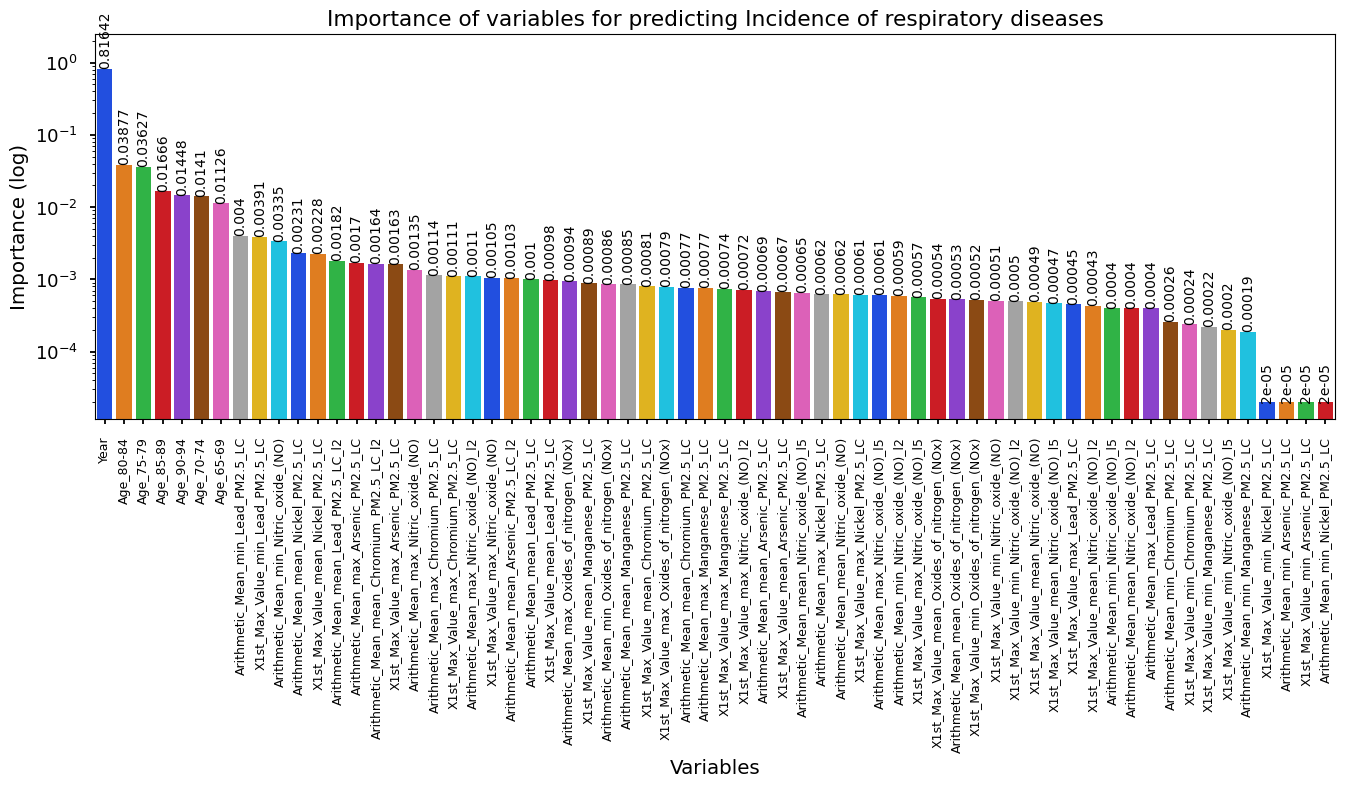

In [208]:
# Visual representation of the feature importance in the Random Forest Regressor Model (with best parameters)

# NOTE: for a better visual representation, variables had to be scaled. 
# Otherwise, Year was too high and the other variables were not visible in the graph

plt.rc('xtick', labelsize=9)

fig, ax = plt.subplots(figsize = (16,5))
sns.barplot(importance_df, x='Variable', y='Importance', palette = 'bright', log = True) # LOG!

ax.bar_label(ax.containers[0], rotation = 90)
ax.set(xlabel='Variables', 
       ylabel='Importance (log)', 
       title='Importance of variables for predicting Incidence of respiratory diseases')
ax.set_ylim(0, 2.5)

plt.xticks(rotation = 90);

In [102]:
# Create data frame for Kaggle submission
kaggle_2 = pd.DataFrame(best_rfr.predict(X_real_test1), columns = ['Incidence'])
kaggle_2['ID'] = X_real_test['ID']

#Saving to csv to submit
kaggle_2.to_csv('kaggle_2A.csv', sep=',', index = False)

### 2. AdaBoost

In [114]:
abr = AdaBoostRegressor(estimator = DecisionTreeRegressor(), n_estimators = 100, random_state = 14)
abr.fit(X_train, y_train)

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100,
                  random_state=14)

In [115]:
print(abr.score(X_train, y_train))
print(abr.score(X_test, y_test))

0.9996095364013285
0.9773428147652264


In [139]:
# Comparing the RMSE

# DataFrame to store predictions
y_test_RMSE['predictions_abr'] = abr.predict(X_test)

#RMSE
np.sqrt(metrics.mean_squared_error(y_test_RMSE['Incidence'], y_test_RMSE['predictions_abr']))

227.67264714979058

In [116]:
# Create data frame for Kaggle submission
kaggle_3 = pd.DataFrame(abr.predict(X_real_test1), columns = ['Incidence'])
kaggle_3['ID'] = X_real_test['ID']

#Saving to csv to submit
kaggle_3.to_csv('kaggle_3A.csv', sep=',', index = False)

### 3. Bagging Regressor

In [153]:
br = BaggingRegressor()

br.fit(X_train, y_train)

C:\Users\adria\anaconda3\Lib\site-packages\sklearn\ensemble\_bagging.py:509: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


BaggingRegressor()

In [154]:
print(br.score(X_train, y_train))
print(br.score(X_test, y_test))

0.9957380125559316
0.9765625392543078


In [155]:
# Comparing the RMSE

# DataFrame to store predictions
y_test_RMSE['predictions_br'] = br.predict(X_test)

#RMSE
np.sqrt(metrics.mean_squared_error(y_test_RMSE['Incidence'], y_test_RMSE['predictions_br']))

231.55979602219722

In [156]:
# Create data frame for Kaggle submission
kaggle_4 = pd.DataFrame(abr.predict(X_real_test1), columns = ['Incidence'])
kaggle_4['ID'] = X_real_test['ID']

#Saving to csv to submit
kaggle_4.to_csv('kaggle_4A.csv', sep=',', index = False)